In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import os
from IPython.display import clear_output
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim





In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
#define value
batch_size = 128
num_epochs = 2000

In [31]:
PATH = 'C:/Users/DELL/Downloads/SimpsonsData/'

In [32]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),          
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [33]:
dataset = ImageFolder(root=PATH, transform=transform)


In [34]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: 3 x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 64 x 32 x 32

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 128 x 16 x 16

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 256 x 8 x 8

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 512 x 4 x 4

            nn.Flatten(),
            #output : 512*4*4
            nn.Linear(in_features=512*4*4,out_features=256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(in_features=256,out_features=1),
            
            nn.Sigmoid()
            # output: 1 x 1 x 1
        )

        

    def forward(self, x):
        return self.main(x)


In [36]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=512, out_features= 2 * 2 * 1024, bias=True),
            
            nn.LeakyReLU(0.5),
            
            nn.Unflatten(1, (1024, 2, 2)),  

            # output : 1024 x 2 x 2
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # output : 512 x 3 x 3
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            #output : 256 x 4 x 4

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            # output: 128 x 8 x 8
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            # output: 64 x 16 x 16

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.01),
            # output: 32 x 32 x 32
            
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            # output: 3 x 64 x 64
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


torch.Size([1, 3, 64, 64])
Min value: 0.4991742968559265 Max value: 0.5009953379631042
(3, 64, 64)


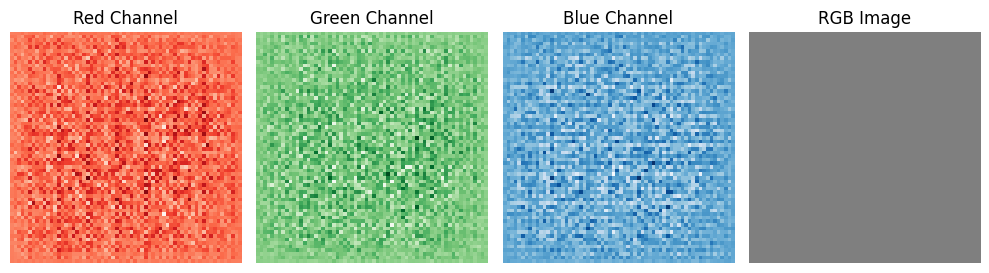

In [37]:
#test generator
random_tensor = torch.randn(1,512)
generator_test = Generator()
result = generator_test(random_tensor)

print(result.shape)
print("Min value:", result.min().item(), "Max value:", result.max().item())

# Tách các kênh màu
red_channel = result.detach().numpy()[0, 0, :, :]  
green_channel = result.detach().numpy()[0, 1, :, :] 
blue_channel = result.detach().numpy()[0, 2, :, :] 

plt.figure(figsize=(10, 4))

# Red channel
plt.subplot(1, 4, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(1, 4, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(1, 4, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')
print(result[0].detach().numpy().shape)
# Stacked RGB image
plt.subplot(1, 4, 4)
plt.imshow(result[0].permute(1,2,0).detach().numpy())
plt.title('RGB Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [38]:
def make_image(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
  noise= torch.randn(examples, 512).to(device)
  generated_images = generator(noise)
  #generated_images = generated_images.reshape(examples,3,128,128)
  plt.figure(figsize=figsize)
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


  for i in range(generated_images.shape[0]):
    # Tách các kênh màu
    red_channel = generated_images.cpu().detach().numpy()[i, 0, :, :]
    green_channel = generated_images.cpu().detach().numpy()[i, 1, :, :]
    blue_channel = generated_images.cpu().detach().numpy()[i, 2, :, :]
    # Ghép các kênh màu lại thành một ảnh RGB
    stacked_image = np.stack((red_channel, green_channel, blue_channel), axis = -1)
    plt.subplot(5, 5, i + 1)
    plt.imshow(stacked_image,interpolation='nearest',cmap='gray_r')
    plt.axis('off')

  

  plt.tight_layout()
  path = 'E:\GAN_result'
  plt.savefig(os.path.join(path,'gan_generated_image %d.png' %epoch))
  plt.close('all')
  # plt.show()

In [39]:
#init the sub-network for GAN

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=8192, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Linear(in_features=256, out_features=1, bias=True)
    (12): Sigmoid()
  )
)

In [69]:
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Generator_optimizer, mode='min', factor=0.5, patience=5)
# D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Discriminator_optimizer, mode='min', factor=0.5, patience=5)


***Train 1***

In [70]:
g_history = []
d_history = []
real_label = 1.
fake_label = 0.
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader), 0):
        # Cập nhật Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Đào tạo với dữ liệu thật
        discriminator.zero_grad()
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_data).view(-1)
        loss_d_real = criterion(output, labels)
        loss_d_real.backward()
        D_x = output.mean().item()

        ## Đào tạo với dữ liệu giả
        noise = torch.randn(batch_size, 512, device=device)
        fake_data = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake_data.detach()).view(-1)
        loss_d_fake = criterion(output, labels)
        loss_d_fake.backward()
        D_G_z1 = output.mean().item()
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()

        # Cập nhật Generator: maximize log(D(G(z)))
        generator.zero_grad()
        labels.fill_(real_label)
        output = discriminator(fake_data).view(-1)
        loss_g = criterion(output, labels)
        loss_g.backward()
        D_G_z2 = output.mean().item()
        optimizer_g.step()

    print(f'[{epoch}/{num_epochs}] '
            f'Loss_D: {loss_d.item():.4f} Loss_G: {loss_g.item():.4f} '
            f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    if epoch % 5 == 0 :
        make_image(epoch,generator)

        
        

100%|██████████| 78/78 [00:25<00:00,  3.07it/s]


[0/2000] Loss_D: 0.0543 Loss_G: 15.9719 D(x): 1.0000 D(G(z)): 0.0525 / 0.0524


 81%|████████  | 63/78 [00:21<00:05,  2.97it/s]


KeyboardInterrupt: 